[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/LastCodeBender42/Protein-Structure-Network-Analysis.git/main?labpath=01_network_centrality_comparisons.ipynb)

# Evaluating Relationships Between Measures of Centrality Using Plotly Multiplots

---

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import plotly.graph_objs as go
from scipy.stats import linregress
# from ipywidgets import widgets, interact
# from IPython.display import display, clear_output

class CentralityAnalysis:
    def __init__(self):
        super().__init__()
        # Initialize graph variable
        self.G = None
        
    def generate_graph(self):
        # Read data and create graph
        df = pd.read_csv('./data/1YOK.cif_ringEdges', sep='\t')
        subset_df = df.loc[(df['NodeId1'].str.contains('A:')) & (df['NodeId2'].str.contains('A:'))]
        self.G = nx.from_pandas_edgelist(subset_df, 'NodeId1', 'NodeId2', create_using=nx.Graph())
        
    def generate_eigenVals(self):
        # Check if graph is generated
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        eigen_centr = nx.eigenvector_centrality_numpy(self.G)
        eigendf = pd.DataFrame(list(eigen_centr.items()), columns=['node', 'value'])
        eigendf['norm_val'] = eigendf['value'] / eigendf['value'].max()
        return eigendf
        
    def generate_closeVals(self):
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        close_centr = nx.closeness_centrality(self.G)
        closedf = pd.DataFrame(list(close_centr.items()), columns=['node', 'value'])
        closedf['norm_val'] = closedf['value'] / closedf['value'].max()
        return closedf
        
    def generate_degrVals(self):
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        degr_centr = nx.degree_centrality(self.G)
        degrdf = pd.DataFrame(list(degr_centr.items()), columns=['node', 'value'])
        degrdf['norm_val'] = degrdf['value'] / degrdf['value'].max()
        return degrdf
        
    def generate_betwVals(self):
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        betw_centr = nx.betweenness_centrality(self.G)
        betwdf = pd.DataFrame(list(betw_centr.items()), columns=['node', 'value'])
        betwdf['norm_val'] = betwdf['value'] / betwdf['value'].max()
        return betwdf
            
    def generate_edgeBetw(self):
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        edge_betw = nx.edge_betweenness_centrality(self.G)
        edge_betwdf = pd.DataFrame(list(edge_betw.items()), columns=['Pair', 'Edge Value'])
        edge_betwdf[['Node1', 'Node2']] = pd.DataFrame(edge_betwdf['Pair'].tolist(), index=edge_betwdf.index)
        edge_betwdf = edge_betwdf[['Node1', 'Node2', 'Edge Value']]
        edge_betwdf['Norm Value'] = edge_betwdf['Edge Value'] / edge_betwdf['Edge Value'].max()
        return edge_betwdf

newGraph = CentralityAnalysis()
newGraph.generate_graph()

datasets = ['eigenVals', 'betwVals', 'degrVals', 'closeVals']
dataframes = {}

for dataset in datasets:
    df = getattr(newGraph, f'generate_{dataset}')()
    df['node'] = df['node'].str.replace(r'\D', '', regex=True)
    df['node'] = pd.to_numeric(df['node'])
    df = df.sort_values(by='node', ascending=True)
    df = df.drop(df.index[-1])
    dataframes[dataset] = df

# Define your dataframes (assuming dataframes is defined elsewhere)
norm_vals = {
    'Eigenvector centrality values': dataframes['eigenVals']['norm_val'],
    'Betweenness centrality values': dataframes['betwVals']['norm_val'],
    'Degree centrality values': dataframes['degrVals']['norm_val'],
    'Closeness centrality values': dataframes['closeVals']['norm_val']
}


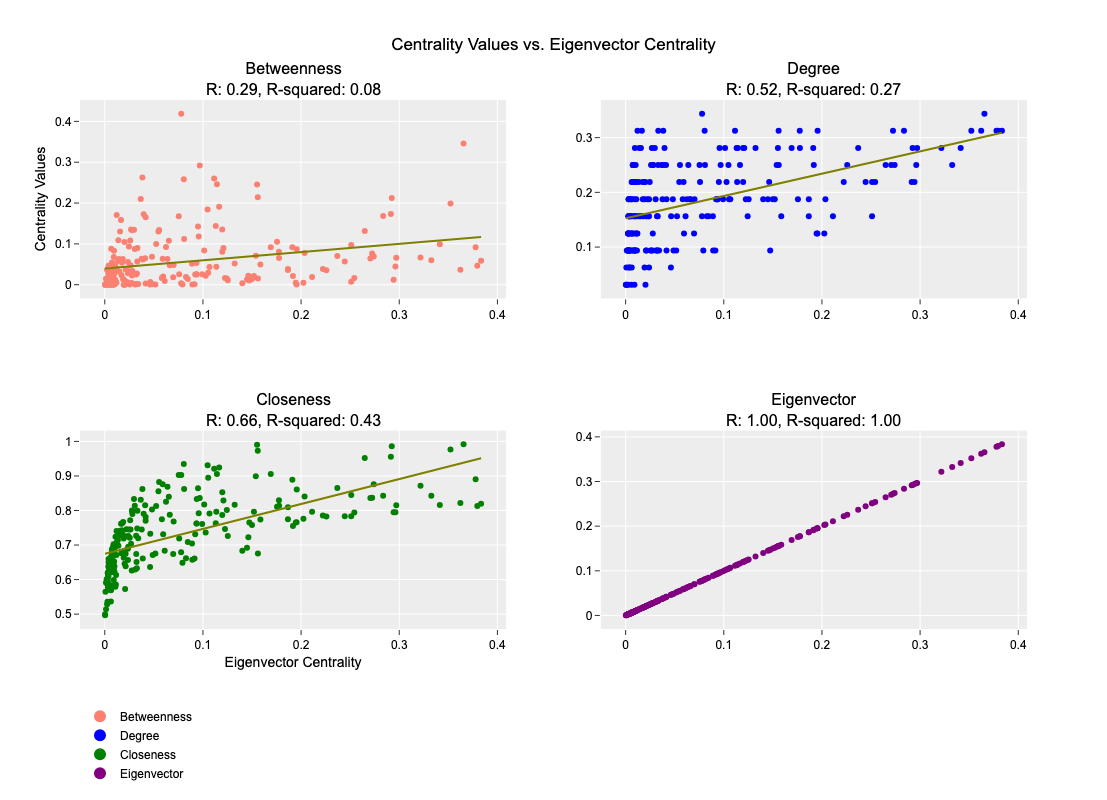

In [2]:
import plotly.subplots as sp
from scipy.stats import linregress

# Define function to create the 2x2 plot
def create_2x2_plot():
    fig = sp.make_subplots(rows=2, cols=2, subplot_titles=('Betweenness', 'Degree', 'Closeness', 'Eigenvector'), shared_xaxes=False, shared_yaxes=False)

    # Define the x-axis data (Eigenvector centrality)
    x_values = norm_vals['Eigenvector centrality values']

    # Define colors for each centrality
    centrality_colors = {'Betweenness': 'salmon', 'Degree': 'blue', 'Closeness': 'green', 'Eigenvector': 'purple'}

    # Define lists to store r and r-squared values for each centrality
    r_values = []
    r_squared_values = []

    # Betweenness centrality
    slope, intercept, r_value, p_value, std_err = linregress(x_values, norm_vals['Betweenness centrality values'])
    regression_line = slope * np.array(x_values) + intercept
    r_values.append(r_value)
    r_squared_values.append(r_value ** 2)
    fig.add_trace(go.Scatter(x=x_values, y=norm_vals['Betweenness centrality values'], mode='markers', name='Betweenness', marker=dict(color=centrality_colors['Betweenness'])), row=1, col=1)
    fig.add_trace(go.Scatter(x=x_values, y=regression_line, mode='lines', showlegend=False, line=dict(color='olive')), row=1, col=1)

    # Degree centrality
    slope, intercept, r_value, p_value, std_err = linregress(x_values, norm_vals['Degree centrality values'])
    regression_line = slope * np.array(x_values) + intercept
    r_values.append(r_value)
    r_squared_values.append(r_value ** 2)
    fig.add_trace(go.Scatter(x=x_values, y=norm_vals['Degree centrality values'], mode='markers', name='Degree', marker=dict(color=centrality_colors['Degree'])), row=1, col=2)
    fig.add_trace(go.Scatter(x=x_values, y=regression_line, mode='lines', showlegend=False, line=dict(color='olive')), row=1, col=2)

    # Closeness centrality
    slope, intercept, r_value, p_value, std_err = linregress(x_values, norm_vals['Closeness centrality values'])
    regression_line = slope * np.array(x_values) + intercept
    r_values.append(r_value)
    r_squared_values.append(r_value ** 2)
    fig.add_trace(go.Scatter(x=x_values, y=norm_vals['Closeness centrality values'], mode='markers', name='Closeness', marker=dict(color=centrality_colors['Closeness'])), row=2, col=1)
    fig.add_trace(go.Scatter(x=x_values, y=regression_line, mode='lines', showlegend=False, line=dict(color='olive')), row=2, col=1)

    # Eigenvector centrality (dots)
    r_values.append(1)  # R-value for straight line (Eigenvector centrality)
    r_squared_values.append(1)  # R-squared for straight line (Eigenvector centrality)
    fig.add_trace(go.Scatter(x=x_values, y=x_values, mode='markers', name='Eigenvector', marker=dict(color=centrality_colors['Eigenvector'])), row=2, col=2)

    # Update subplot titles with R and R-squared values
    for i, (title, r_value, r_squared) in enumerate(zip(fig.layout.annotations, r_values, r_squared_values)):
        title.text += f'<br>R: {r_value:.2f}, R-squared: {r_squared:.2f}'

    # Update layout
    fig.update_layout(template='ggplot2',  # Set theme to ggplot2-like
                      font=dict(family="Arial", size=12, color="black"),
                      legend=dict(x=0, y=-0.30, traceorder="normal", itemsizing='constant'),  # Adjust itemsizing to avoid resizing
                      title_text="Centrality Values vs. Eigenvector Centrality",
                      width=1000, height=800,
                      xaxis=dict(title=dict(text='Eigenvector Centrality', standoff=335),  # Set x-axis label
                                 tickfont=dict(size=12)),  # Set x-axis tick font size
                      yaxis=dict(title=dict(text='Centrality Values', standoff=0),  # Set y-axis label
                                 tickfont=dict(size=12)))  # Set y-axis tick font size
    fig.show()

# Call the function to create the 2x2 plot
create_2x2_plot()


---
# **An Image of the Result:**
---

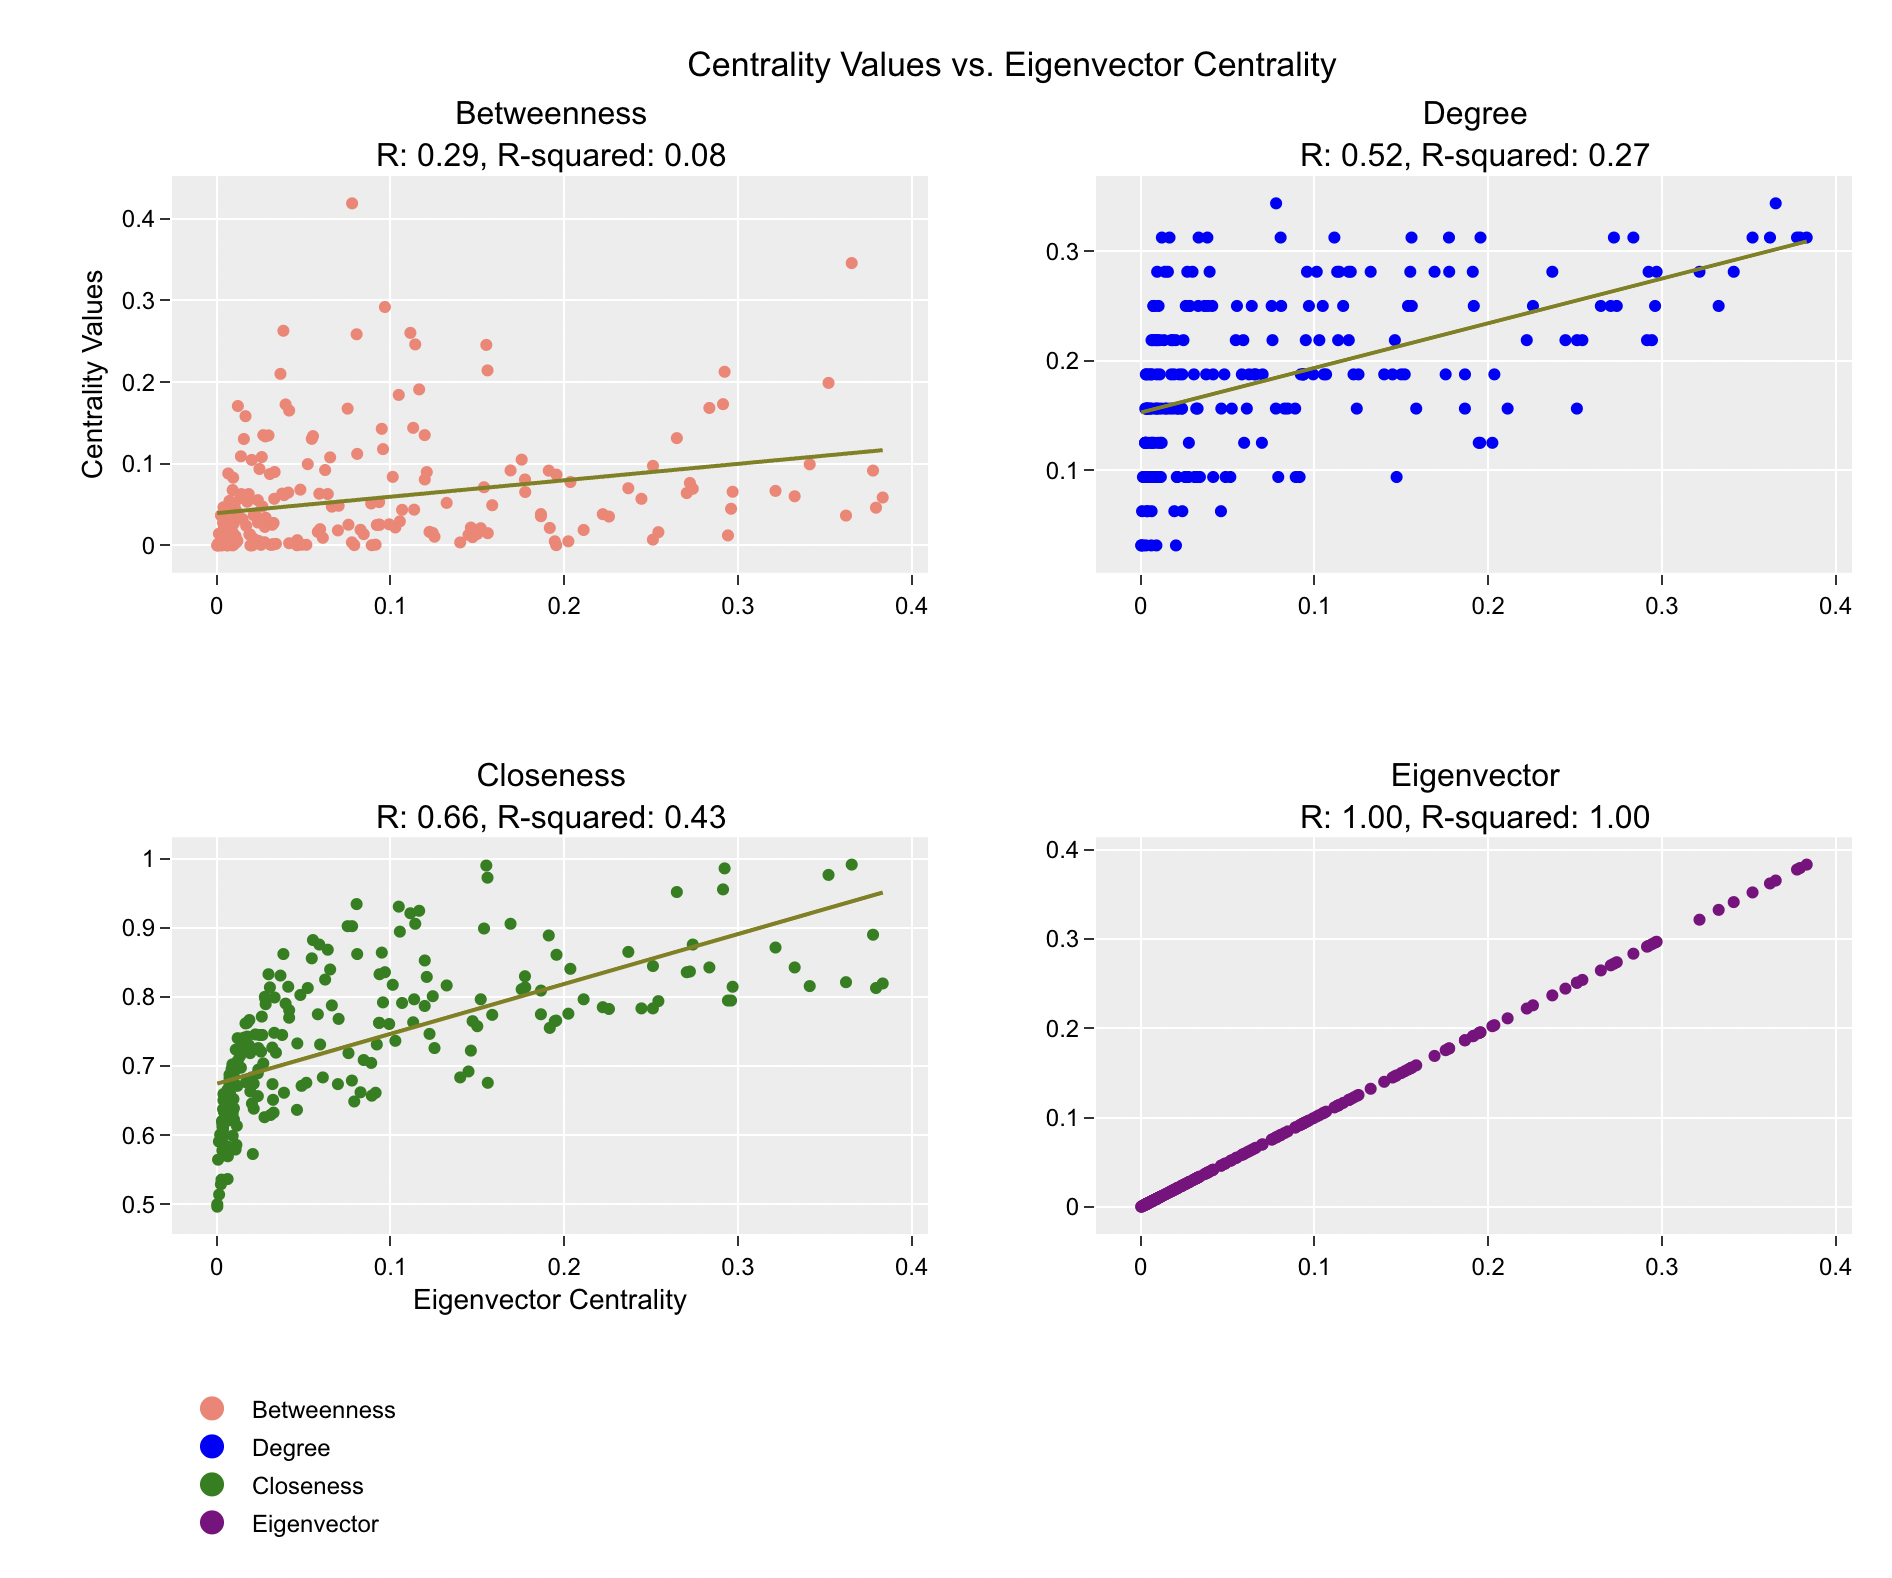